In [1]:
from gpaw import GPAW, FermiDirac
from gpaw.wavefunctions.pw import PW
from ase import Atoms
from TDDFT import TDDFT
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

a = 2.5
c = 15
PW_cut=800
nbands=8
atoms = Atoms(symbols='C2', positions=[(0.5 * a, -np.sqrt(3) / 6 * a, 0.5*c),
                                    (0.5 * a, np.sqrt(3) / 6 * a, 0.5*c)],
           cell=[(0.5 * a, -0.5 * 3**0.5 * a, 0),
                 (0.5 * a, 0.5 * 3**0.5 * a, 0),
                 (0.0, 0.0, c )], pbc=True)

calc = GPAW(mode=PW(PW_cut),xc='PBE',
            kpts={'size': (4, 4, 1), 'gamma': True},
            setups='sg15',
            nbands=2*nbands,
            occupations=FermiDirac(0.001),
            convergence={'bands': nbands},
            txt='calc.txt')

atoms.set_calculator(calc)
atoms.get_potential_energy()
calc.write('gs.gpw')

/home/yzhumagulov/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.ifft(a, n, axis)


In [2]:
tddft=TDDFT(calc)

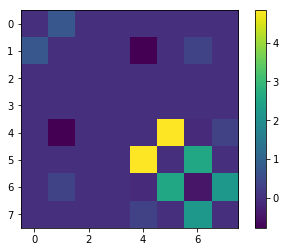

In [3]:
dipole=tddft.get_dipole_matrix()
plt.imshow(dipole[0].real)
plt.colorbar()

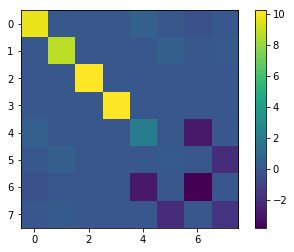

In [4]:
VH_matrix=tddft.get_Hartree_matrix()
plt.imshow(VH_matrix[0].real)
plt.colorbar()

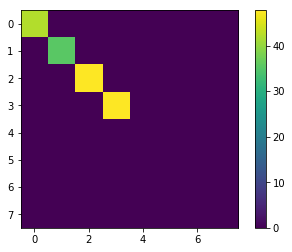

In [5]:
VF_matrix=tddft.get_Fock_matrix()
plt.imshow(VF_matrix[0].real)
plt.colorbar()

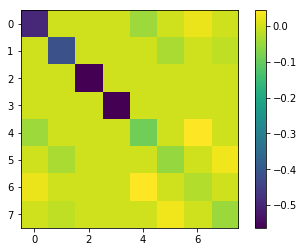

In [6]:
LDAx_matrix=tddft.get_LDA_exchange_matrix()
plt.imshow(LDAx_matrix[0].real)
plt.colorbar()

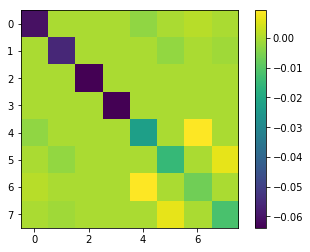

In [7]:
LDAc_matrix=tddft.get_LDA_correlation_matrix()
plt.imshow(LDAc_matrix[0].real)
plt.colorbar()